In [2]:
import pandas as pd
#telco customer churn data
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.shape

(7043, 21)

In [4]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [5]:
#unique identifier not needed
data = df.drop('customerID', axis=1) 

In [6]:
#convert
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce")
data["TotalCharges"] = data["TotalCharges"].fillna(data["TotalCharges"].median())

#encode
yes_no_cols = ["Partner", "Dependents", "PhoneService", "PaperlessBilling", "Churn"]
for col in yes_no_cols:
    data[col] = data[col].map({"Yes":1, "No":0})
    
#one-hot encode multi category features
multi_cats = [
    "gender", "MultipleLines", "InternetService", "OnlineSecurity",
    "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV",
    "StreamingMovies", "Contract", "PaymentMethod"
]

data = pd.get_dummies(data, columns=multi_cats)


In [7]:
from sklearn.preprocessing import StandardScaler

num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])
data.head(5)

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,gender_Female,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,-1.277445,0,1,-1.160323,-0.994242,0,True,...,True,False,False,True,False,False,False,False,True,False
1,0,0,0,0.066327,1,0,-0.259629,-0.173244,0,False,...,True,False,False,False,True,False,False,False,False,True
2,0,0,0,-1.236724,1,1,-0.362660,-0.959674,1,False,...,True,False,False,True,False,False,False,False,False,True
3,0,0,0,0.514251,0,0,-0.746535,-0.194766,0,False,...,True,False,False,False,True,False,True,False,False,False
4,0,0,0,-1.236724,1,1,0.197365,-0.940470,1,True,...,True,False,False,True,False,False,False,False,True,False


In [60]:
from sklearn.model_selection import train_test_split
X = data.drop("Churn", axis=1)
y = data["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train = X_train.astype("float64")
X_test = X_test.astype("float64")

In [61]:
#SMOTE FOR OVERSAMPLING (only to training data)
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print(f"Before SMOTE: Class 0 = {sum(y_train==0)}, Class 1 = {sum(y_train==1)}")

print(f"After SMOTE: Class 0 = {sum(y_train_balanced==0)}, Class 1 = {sum(y_train_balanced==1)}")


Before SMOTE: Class 0 = 4139, Class 1 = 1495
After SMOTE: Class 0 = 4139, Class 1 = 4139


## For imblanced dataset

In [89]:
import numpy as np

# Manual MCMC for Bayesian Logistic Regression
def sigmoid(x):
    """Manual sigmoid without scipy"""
    return 1 / (1 + np.exp(-x))

def log_posterior(X, y, w, b):
    """Calculate log posterior: prior N(0,1) + Bernoulli likelihood"""
    # Priors: N(0,1) for all parameters
    log_prior = -0.5 * np.sum(w**2) - 0.5 * b**2
    
    # Likelihood: Bernoulli with logistic link
    logits = b + X @ w
    p = sigmoid(logits)
    p = np.clip(p, 1e-10, 1 - 1e-10)  # Avoid log(0)
    log_lik = np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
    
    return log_prior + log_lik


# MCMC parameters
n_iter = 2000
n_features = X_train.shape[1]

# Initialize
np.random.seed(42)
w = np.zeros(n_features)
b = 0
w_samples = []
b_samples = []
w_samples_full=[]

# MCMC sampling
log_p_current = log_posterior(X_train.values, y_train.values, w, b)
accept_count = 0

for i in range(n_iter):
    # Propose new values with random walk
    w_proposal = w + 0.02 * np.random.randn(n_features)
    b_proposal = b + 0.02 * np.random.randn()
    
    log_p_proposal = log_posterior(X_train.values, y_train.values, w_proposal, b_proposal)
    
    # Metropolis acceptance
    if np.log(np.random.rand()) < (log_p_proposal - log_p_current):
        w, b = w_proposal, b_proposal
        log_p_current = log_p_proposal
        accept_count += 1
    
    # Store every 5th sample after burn-in of 18%
    if i >= 360 and i % 5 == 0:
        w_samples.append(w.copy())
        b_samples.append(b)
    w_samples_full.append(w.copy()) #used to assess what is a good burn-in below    

w_samples = np.array(w_samples)
b_samples = np.array(b_samples)

# Posterior means 
w_mean = w_samples.mean(axis=0)
b_mean = b_samples.mean()

# Predictions
logits_test = b_mean + np.dot(X_test, w_mean)
prob_blr = sigmoid(logits_test)
pred_blr = (prob_blr > 0.5).astype(int)

print(f"Acceptance rate: {accept_count/n_iter:.3f}")
print(f"Test accuracy: {np.mean(pred_blr == y_test):.3f}")

Acceptance rate: 0.336
Test accuracy: 0.803


In [90]:
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, pred_blr))
print("ROC-AUC:", roc_auc_score(y_test, prob_blr))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.55      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409

ROC-AUC: 0.8418533157663592


## For balanced dataset

In [91]:
# MCMC parameters
n_iter = 3000
n_features = X_train_balanced.shape[1]

# Initialize
np.random.seed(42)
w = np.zeros(n_features)
b = 0
w_samples2 = []
b_samples2 = []
w_samples_full2=[]

# MCMC sampling
log_p_current = log_posterior(X_train_balanced.values, y_train_balanced.values, w, b)
accept_count = 0

for i in range(n_iter):
    # Propose new values with random walk
    w_proposal = w + 0.02 * np.random.randn(n_features)
    b_proposal = b + 0.02 * np.random.randn()
    
    log_p_proposal = log_posterior(X_train_balanced.values, y_train_balanced.values, w_proposal, b_proposal)
    
    # Metropolis acceptance
    if np.log(np.random.rand()) < (log_p_proposal - log_p_current):
        w, b = w_proposal, b_proposal
        log_p_current = log_p_proposal
        accept_count += 1
    
    # Store every 3rd sample after burn-in of 18%
    if i >= 360 and i % 3 == 0:
        w_samples2.append(w.copy())
        b_samples2.append(b)
    w_samples_full2.append(w.copy()) #used to assess what is a good burn-in below 
    
w_samples2 = np.array(w_samples2)
b_samples2 = np.array(b_samples2)

# Posterior means
w_mean2 = w_samples2.mean(axis=0)
b_mean2 = b_samples2.mean()

# Predictions
logits_test2 = b_mean2 + np.dot(X_test, w_mean2)
prob_blr2 = sigmoid(logits_test2)
pred_blr2 = (prob_blr2 > 0.5).astype(int)

print(f"Acceptance rate: {accept_count/n_iter:.3f}")
print(f"Test accuracy: {np.mean(pred_blr2 == y_test):.3f}")

Acceptance rate: 0.211
Test accuracy: 0.740


In [92]:
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, pred_blr2))
print("ROC-AUC:", roc_auc_score(y_test, prob_blr2))

              precision    recall  f1-score   support

           0       0.90      0.73      0.80      1035
           1       0.51      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

ROC-AUC: 0.8392699372239014


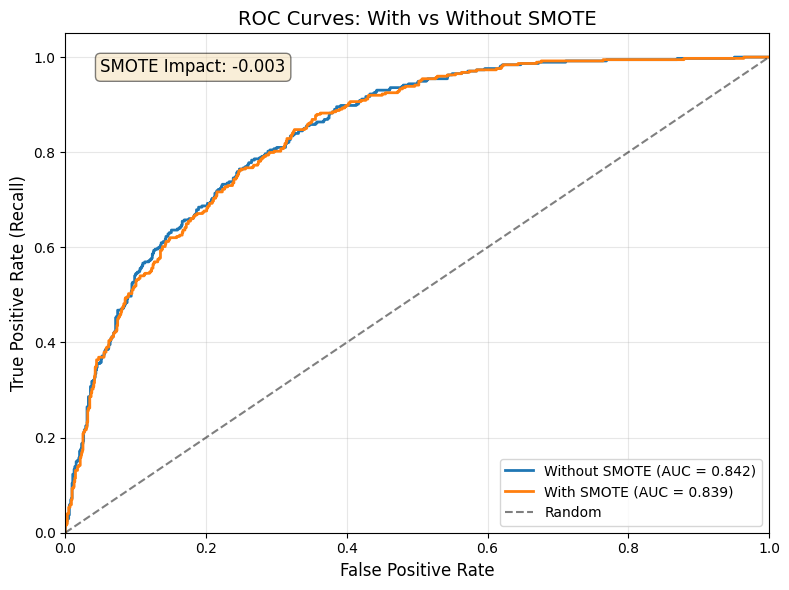

In [93]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 6))

# Without SMOTE
fpr1, tpr1, _ = roc_curve(y_test, prob_blr)
roc_auc1 = auc(fpr1, tpr1)
ax.plot(fpr1, tpr1, label=f'Without SMOTE (AUC = {roc_auc1:.3f})', linewidth=2)

# With SMOTE
fpr2, tpr2, _ = roc_curve(y_test, prob_blr2)
roc_auc2 = auc(fpr2, tpr2)
ax.plot(fpr2, tpr2, label=f'With SMOTE (AUC = {roc_auc2:.3f})', linewidth=2)

# Diagonal line
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate (Recall)', fontsize=12)
ax.set_title('ROC Curves: With vs Without SMOTE', fontsize=14)
ax.legend(loc='lower right')
ax.grid(alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

# Add AUC values in text box
textstr = f'SMOTE Impact: {roc_auc2-roc_auc1:.3f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

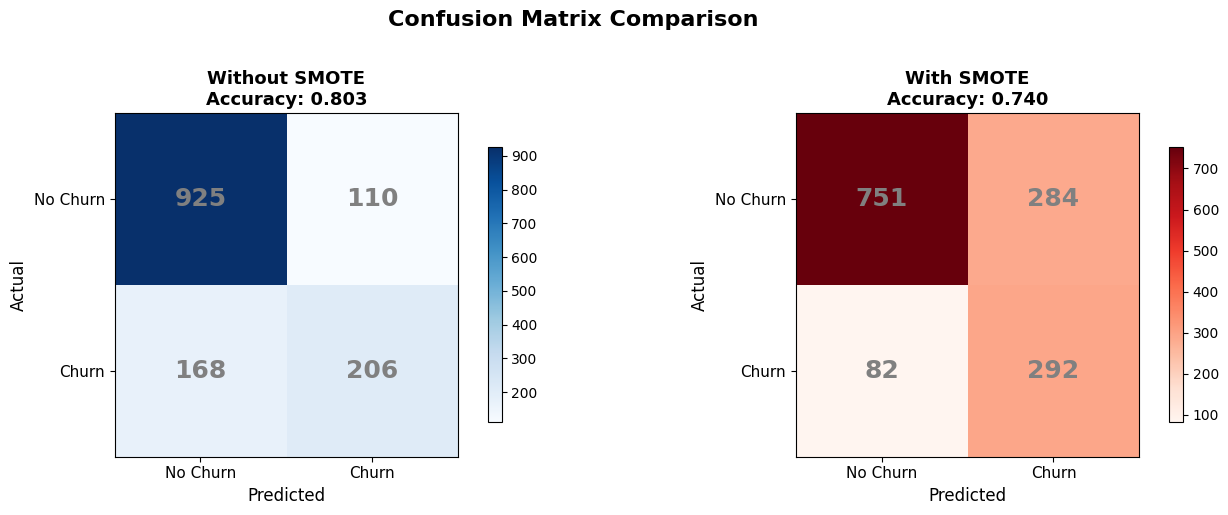

In [95]:
from sklearn.metrics import confusion_matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Without SMOTE
cm1 = confusion_matrix(y_test, pred_blr)
im1 = axes[0].imshow(cm1, cmap='Blues', interpolation='nearest')

# Add text to first plot
for i in range(cm1.shape[0]):
    for j in range(cm1.shape[1]):
        axes[0].text(j, i, str(cm1[i, j]),
                    ha='center', va='center',
                    color='grey',
                    fontsize=18, fontweight='bold')

axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_title(f'Without SMOTE\nAccuracy: {np.mean(pred_blr == y_test):.3f}', 
                  fontsize=13, fontweight='bold')
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['No Churn', 'Churn'], fontsize=11)
axes[0].set_yticklabels(['No Churn', 'Churn'], fontsize=11, rotation=0)
axes[0].grid(False)

# With SMOTE
cm2 = confusion_matrix(y_test, pred_blr2)
im2 = axes[1].imshow(cm2, cmap='Reds', interpolation='nearest')

# Add text to second plot
for i in range(cm2.shape[0]):
    for j in range(cm2.shape[1]):
        axes[1].text(j, i, str(cm2[i, j]),
                    ha='center', va='center',
                    color='grey',
                    fontsize=18, fontweight='bold')

axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_title(f'With SMOTE\nAccuracy: {np.mean(pred_blr2 == y_test):.3f}', 
                  fontsize=13, fontweight='bold')
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['No Churn', 'Churn'], fontsize=11)
axes[1].set_yticklabels(['No Churn', 'Churn'], fontsize=11, rotation=0)
axes[1].grid(False)

# Add colorbars
plt.colorbar(im1, ax=axes[0], shrink=0.8)
plt.colorbar(im2, ax=axes[1], shrink=0.8)

plt.suptitle('Confusion Matrix Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

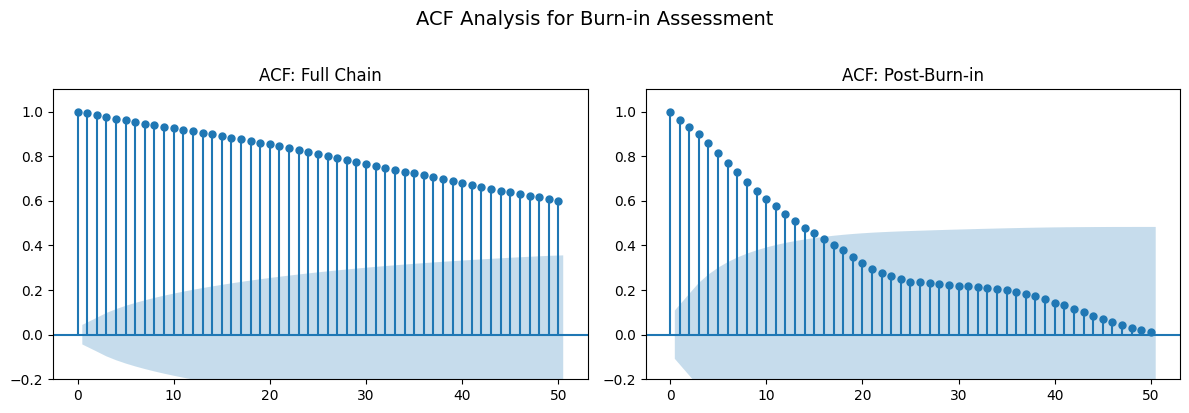

In [109]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Plot ACF
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
w_samples_full = np.array(w_samples_full)


# Plot 1 : ACF of full chain
plot_acf(w_samples_full[:, 0], ax=axes[0], lags=50, 
         title='ACF: Full Chain')
axes[0].set_ylim([-0.2, 1.1])



# Plot 2: ACF of post-burn-in
#tried 18% of 2000 and other burn in rates - added thinning based on ACF plot results
post_burnin = w_samples_full[360:, 0][::5]  
plot_acf(post_burnin, ax=axes[1], lags=50, 
         title='ACF: Post-Burn-in')
axes[1].set_ylim([-0.2, 1.1])

plt.suptitle('ACF Analysis for Burn-in Assessment', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

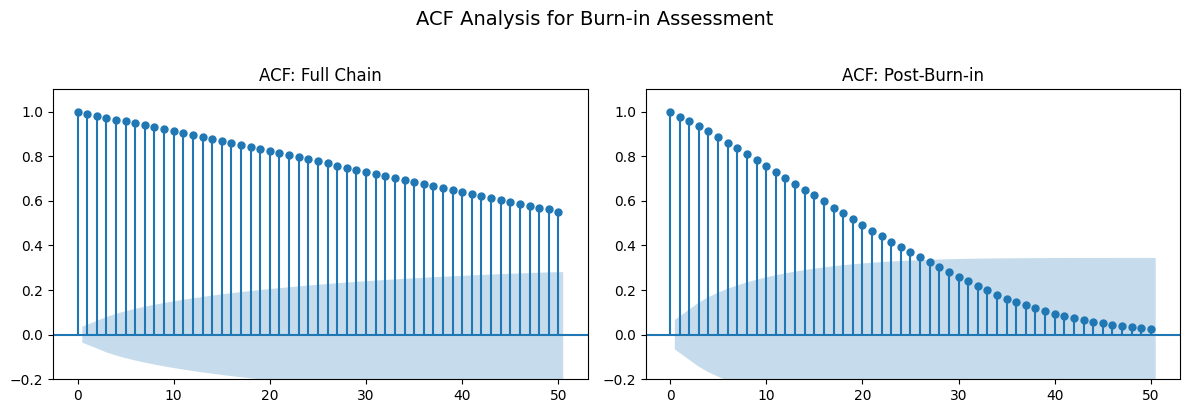

In [107]:
# Plot ACF
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
w_samples_full2 = np.array(w_samples_full2)


# Plot 1 : ACF of full chain
plot_acf(w_samples_full2[:, 0], ax=axes[0], lags=50, 
         title='ACF: Full Chain')
axes[0].set_ylim([-0.2, 1.1])



# Plot 2: ACF of post-burn-in
#tried 18% of 2000 and other burn in rates - added thinning based on ACF plot results
post_burnin = w_samples_full2[360:, 0][::3]  
plot_acf(post_burnin, ax=axes[1], lags=50, 
         title='ACF: Post-Burn-in')
axes[1].set_ylim([-0.2, 1.1])

plt.suptitle('ACF Analysis for Burn-in Assessment', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [94]:
import matplotlib.pyplot as plt
# After running your MCMC, get feature importance
w_mean = w_samples.mean(axis=0)  # Posterior mean weights
features = X_train.columns

# Calculate importance (absolute weight magnitude + uncertainty)
w_std = w_samples.std(axis=0)  # Posterior standard deviation
importance_scores = np.abs(w_mean) / (w_std + 1e-10)  # Signal-to-noise ratio

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': features,
    'weight_mean': w_mean,
    'weight_std': w_std,
    'importance': importance_scores
}).sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
top_n = 41 #all features
top_features = importance_df.head(top_n)

top_features
# # Plot with error bars (posterior uncertainty)
# plt.barh(range(top_n), top_features['weight_mean'].values)
# plt.yticks(range(top_n), top_features['feature'].values)
# plt.xlabel('Posterior Mean Weight')
# plt.title(f'Top {top_n} Most Important Features')
# plt.grid(axis='x', alpha=0.3)
# plt.tight_layout()
# plt.show()


,feature,weight_mean,weight_std,importance
13,InternetService_DSL,-0.692515,0.078542,8.817109
4,PhoneService,-0.619917,0.102165,6.067793
28,StreamingTV_No,-0.495545,0.098673,5.022090
6,MonthlyCharges,0.333881,0.071836,4.647856
16,OnlineSecurity_No,0.380516,0.084619,4.496815
5,PaperlessBilling,0.361076,0.087740,4.115277
15,InternetService_No,-0.403285,0.099894,4.037147
36,Contract_Two year,-0.723430,0.188281,3.842295
3,tenure,-0.977971,0.254576,3.841566
34,Contract_Month-to-month,0.442091,0.124463,3.551986


<Figure size 1000x600 with 0 Axes>